In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Train Models 
In this notebook i'll try different models and see which one is better. As i said simpler models will work best here, but i'll use LGBM and an ANN just for trying.

In [3]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

In [4]:
X_train.set_index('key_0',inplace = True)
X_train.drop(columns = ['Unnamed: 0'],inplace = True)

In [5]:
y_train.set_index('Unnamed: 0',inplace = True)

In [6]:
X_test.set_index('Unnamed: 0',inplace = True)

In [7]:
y_test.set_index('Unnamed: 0',inplace = True)

Here i import the feature_engineering from the DataTestProcess.py module i created.  

In [9]:
from DataTestProcess import feature_engineering

In [10]:
X_test = feature_engineering(X_test)

#### KNN

In [12]:
#knn
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE

In [13]:
steps_knn = [('feat_selector',SelectKBest(k=10)),('scaler' , StandardScaler()),('knn' , KNeighborsClassifier())]
pipe_grid_knn = Pipeline (steps_knn)

In [14]:
pipe_param_knn = [{'feat_selector__k' :[5,10,len(X_train.columns)],
                   'scaler' : [RobustScaler(),StandardScaler(),None],                          
                   'knn__n_neighbors' : list(range(2,20,2)),
                   'knn__weights' : ['uniform','distance'],
                   'knn__p' : [1,2] }]    

In [15]:
gird_knn =  GridSearchCV (pipe_grid_knn, pipe_param_knn ,cv = 5 , n_jobs = -1)
gird_knn.fit(X_train,y_train)
gird_knn.best_params_

{'feat_selector__k': 10,
 'knn__n_neighbors': 14,
 'knn__p': 1,
 'knn__weights': 'uniform',
 'scaler': StandardScaler()}

In [16]:
gird_knn.best_score_

0.8571951219512195

In [17]:
from sklearn.metrics import accuracy_score
pred = gird_knn.predict(X_test)
accuracy_score(y_test,pred)

0.84

<AxesSubplot:>

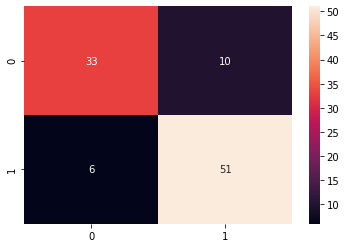

In [18]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,pred),annot = True)

#### Logistic

In [19]:

from sklearn.linear_model import LogisticRegression
steps_log = [('feat_selector',SelectKBest(k=10)),('scaler' , StandardScaler()),('logistic' , LogisticRegression(max_iter = 1000))]
pipe_grid_log = Pipeline (steps_log )


In [20]:
pipe_param_log = [{'feat_selector__k' :[5,10,len(X_train.columns)],
                  'scaler' : [RobustScaler(),StandardScaler(),None],
                   'logistic__C' : [0.01,0.1,1,100,10**10000],
                  'logistic__penalty' : ['l1','l2'],
                  'logistic__solver' : ["liblinear","lbfgs"],
                  'logistic__fit_intercept' : [True,False]}]  

In [21]:
gird_log =  GridSearchCV (pipe_grid_log, pipe_param_log ,cv = 5 , n_jobs = -1)
gird_log.fit(X_train,y_train)
gird_log.best_params_

{'feat_selector__k': 10,
 'logistic__C': 0.1,
 'logistic__fit_intercept': False,
 'logistic__penalty': 'l2',
 'logistic__solver': 'liblinear',
 'scaler': RobustScaler()}

In [22]:
gird_log.best_score_

0.8518292682926829

In [23]:
from sklearn.metrics import accuracy_score
pred = gird_log.predict(X_test)
accuracy_score(y_test,pred)

0.8

<AxesSubplot:>

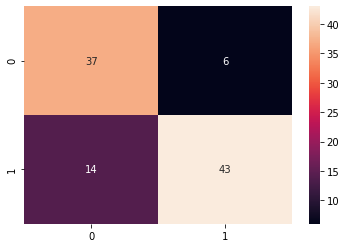

In [24]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,pred),annot = True)

#### LGBM

In [26]:
#ligthgbm

import lightgbm as lgb
from sklearn.preprocessing import RobustScaler

steps_lgb = [('feat_selector',SelectKBest(k=10)),('scaler' , RobustScaler()),('lgb' , lgb.LGBMClassifier(objective = 'binary'))]
pipe_grid_lgb = Pipeline (steps_lgb)

param_grid_lgb = [{'feat_selector__k' :[5,10,len(X_train.columns)],
                   'scaler' : [RobustScaler(),StandardScaler(),None],                
                  'lgb__n_estimators' : [100,300,500,900,1000],
                  'lgb__eta' : [0.01,0.1,1],
                  'lgb__boosting' : ['gbdt','dart']     
                }]

In [27]:
grid_lgb_full =  GridSearchCV (pipe_grid_lgb, param_grid_lgb ,cv = 3,n_jobs = -1)
grid_lgb_full.fit(X_train,y_train)
grid_lgb_full.best_params_

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.01 will be ignored. Current value: learning_rate=0.1


{'feat_selector__k': 10,
 'lgb__boosting': 'dart',
 'lgb__eta': 0.01,
 'lgb__n_estimators': 100,
 'scaler': StandardScaler()}

In [28]:
grid_lgb_full.best_score_

0.8079455662862159

In [29]:
pred = grid_lgb_full.predict(X_test)
accuracy_score(y_test,pred)

0.82

<AxesSubplot:>

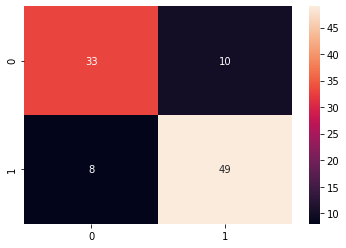

In [30]:
sns.heatmap(confusion_matrix(y_test,pred),annot = True)

#### ANN

In [31]:
#ann
import tensorflow as tf

In [32]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [33]:
ann = tf.keras.Sequential()
ann.add(tf.keras.layers.Dense(units=5,activation = 'relu'))
ann.add(tf.keras.layers.Dense(units=5,activation = 'relu'))
ann.add(tf.keras.layers.Dense(units=1,activation = 'sigmoid'))
ann.compile(optimizer = "adam" ,loss = "binary_crossentropy" , metrics = ["accuracy"])
ann.fit(X_train_std,y_train,batch_size = 32,epochs = 400,verbose = False)

In [34]:
X_test_std = scaler.transform(X_test)

In [35]:
pred = ann.predict(X_test_std) > 0.5

In [36]:
accuracy_score(y_test,pred)

0.81

<AxesSubplot:>

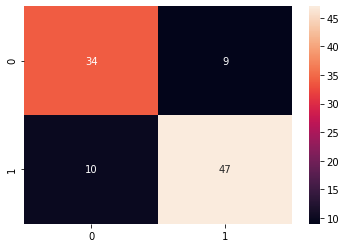

In [37]:
sns.heatmap(confusion_matrix(y_test,pred),annot = True)

#### Choose model

I'll compare logistic and knn with ROC and AUC

In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [39]:
y_probs_knn = gird_knn.predict_proba(X_test)
y_pred_log = gird_log.predict_proba(X_test)

In [40]:
fpr_knn,tpr__knn,thr__knn = roc_curve(y_test, y_probs_knn[:,1])
fpr_log,tpr_log,thr_log = roc_curve(y_test, y_pred_log[:,1])

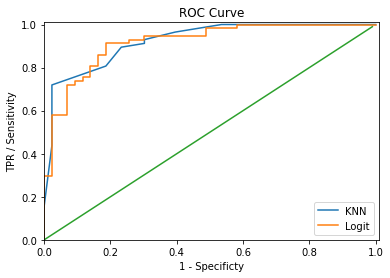

In [41]:
plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_knn,tpr__knn)
plt.plot(fpr_log,tpr_log)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['KNN','Logit'])
plt.show() 

In [42]:
print('AUC knn=', auc(fpr_knn, tpr__knn))
print('AUC log=', auc(fpr_log, tpr_log))

AUC knn= 0.9241126070991431
AUC log= 0.9171766625866993


#### I'll use the KNN model.
Next ill see what happens when i change threshold. As i said before i'll use accuracy to select model, and threshold will remain at 0.5 ,but i'll try and see what happens nonetheless

In [55]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [56]:
pred = gird_knn.predict(X_test)
accuracy_score(y_test,pred)

0.84

With threshold 0.5

<AxesSubplot:>

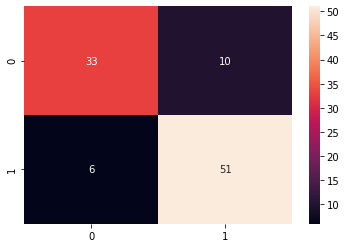

In [57]:
sns.heatmap(confusion_matrix(y_test,pred),annot = True)

In [47]:
precision_score(y_test,pred, average='macro')

0.8411097099621689

In [48]:
recall_score(y_test,pred, average='macro')

0.8310893512851898

Change threshold to 0.3

In [49]:
pred_proba = pd.DataFrame((gird_knn.predict_proba(X_test)>0.3)[:,1])

In [51]:
pred_proba.head()

,0
0,True
1,False
2,False
3,False
4,False


<AxesSubplot:>

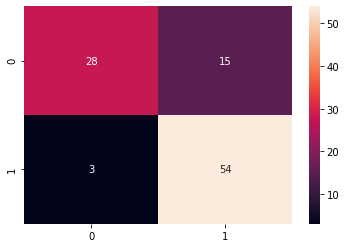

In [52]:
sns.heatmap(confusion_matrix(y_test,pred_proba),annot = True)

More TP predicted at the cost of more FP. As we said earlier this would be better because you are predicting heart problems, so better to say you have and be wrong that saying you dont have heart problems when you have. But again, i'll stay with the 0.5 threshold.

In [53]:
recall_score(y_test,pred_proba, average='macro')

0.799265605875153

In [54]:
precision_score(y_test,pred_proba, average='macro')

0.8429172510518934

In [58]:
import pickle
with open('model_KNN.pkl', 'wb') as f_model:
    pickle.dump(gird_knn,f_model)